In [1]:
%matplotlib inline

# libraries for imbalanced learning
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE,KMeansSMOTE, ADASYN

import pandas as pd
import numpy as np

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Echonest audio features - IMBALANCED LEARNING
## 1. Premise
The hyper-parameters and results for unbalanced classifiers are taken  from the notebooks:
- bin-genre_decision-tree_KNN  (section 2)

Sinci in our previous analysis we found out that both Decision Tree and KNN had higher performances with PCA, we decided to improve our results starting from those classifiers.

__________________________________
# 2 Binary genre - ROCK & JAZZ
__________________________________
## a) Import dataset

In [4]:
binclass_dataset = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Datasets/echo_audiofeatures_outlierfree.csv')
binclass_dataset.set_index('track_id', inplace=True)
#binclass_dataset.drop('listens',axis=1, inplace=True)
#binclass_dataset.drop('comments',axis=1, inplace=True)
#binclass_dataset = binclass_dataset[binclass_dataset['genre_top'].isin(['Rock','Jazz'])]
binclass_dataset.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,...,outlier_LOF,outlier_KNN,outlier_ABOD,outlier_IF-PCA,outlier_EIF-PCA,outlier_IF,outlier_EIF,outlier_IF_sklearn,outlier_AutoEncoder,Winner
track_id,,,,,,,,,,,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,0.788251,128.537,82,256,...,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,0.650452,120.790,326,256,...,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,0.682397,135.468,354,256,...,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,0.917613,120.218,232,256,...,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,0.034018,90.241,405,256,...,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier


### Preprocessing

In [7]:
# remove cols of outliers detection
binclass_dataset = binclass_dataset.iloc[:,:10]

# import labels
genre_top = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Labels/genre_labels.csv')
genre_top.set_index('track_id', inplace=True)

# merge labels and dataset
binclass_dataset = binclass_dataset.merge(genre_top, on='track_id')
binclass_dataset.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,genre_top
track_id,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,0.788251,128.537,82,256,Jazz
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,0.650452,120.790,326,256,Jazz
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,0.682397,135.468,354,256,Jazz
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,0.917613,120.218,232,256,Jazz
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,0.034018,90.241,405,256,Rock


[]

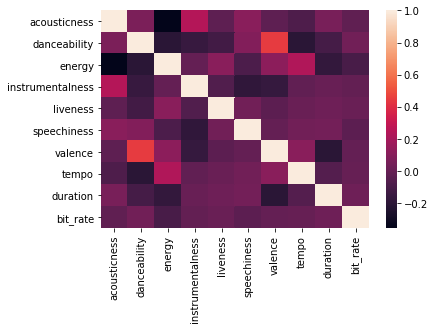

In [8]:
corr = binclass_dataset.corr()
sns.heatmap(corr)
plt.plot()

The highest correlation is the one between valence and danceability ***approximately 0.5***<br>
This makes sense. If a song can be danced it means it is an happy song.
Also the correlation between energy and tempo is easily explainable.

In [11]:
print('Class distribution before balancing')
pd.concat(
    [binclass_dataset.genre_top.value_counts(),
                round(binclass_dataset.genre_top.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

Class distribution before balancing


,counts,percentage (%)
Rock,3892,94.17
Jazz,241,5.83


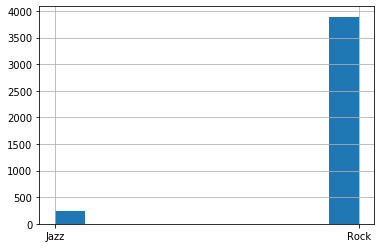

In [12]:
binclass_dataset['genre_top'].hist()

In [13]:
# Data preprocessing
le = preprocessing.LabelEncoder()
binclass_dataset['genre_top'] = le.fit_transform(binclass_dataset['genre_top'])
print('Legend:\n0: Jazz\n1: Rock')
# Define the labels
labels = binclass_dataset[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels[['genre_top']]

Legend:
0: Jazz
1: Rock


In [14]:
# remove labels from dataset
binclass_dataset.drop('genre_top', axis=1, inplace=True)

In [15]:
labels.head()

,genre_top
0,0
1,0
2,0
3,0
4,1


In [16]:
# normalize the dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(binclass_dataset)

## b) Compute PCA and plot distribution in 2D

In [17]:
# compute PCA using optimal number of components: 8 ( discovered in the notebook mentioned above)
pca = PCA(8,random_state=42)
pca.fit(scaled_features)
X_pca = pca.transform(scaled_features)

In [18]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_pca, labels, test_size=0.30, random_state=42, stratify=labels)


In [19]:
# development set shape
X.shape, y.shape

((2893, 8), (2893, 1))

In [20]:
# internal test shape
X_test.shape, y_test.shape

((1240, 8), (1240, 1))

In [21]:
print('Class distribution before balancing after splitting in train test')
pd.concat(
    [y.value_counts(),
                round(y.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

Class distribution before balancing after splitting in train test


,counts,percentage (%)
genre_top,,
1,2724,94.16
0,169,5.84


In [23]:
# function for plotting data in 2D with PCA
def pca_2D(data, y, graph_title):
    """
    This function plots in 2D the features of X.
    :param X: array of features
    :param y: labels
    :param graph_title: title to be displayed on the graph
    :return: 2D scatter-plot
    """
    # dataframe for plotting PCA
    df = pd.DataFrame()
    df['pca1'] = data[:,0]
    df['pca2'] = data[:,1]
    df['genres'] = le.inverse_transform(y)
    # plot scatter of PCA
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="pca1", y="pca2",
        hue='genres',
        palette={'Jazz':'darkblue','Rock':'coral'},
        data=df,
        legend="full",
        alpha=0.5
    )
    plt.title(graph_title, fontsize= 15)
    plt.show()

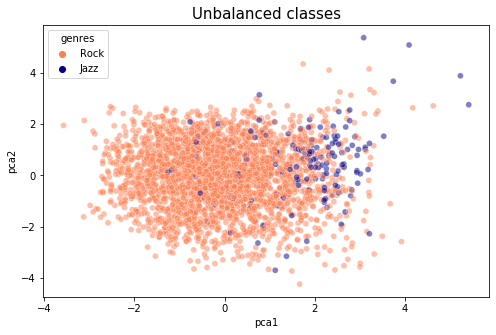

In [24]:
pca_2D(X, y,'Unbalanced classes')

## c) Imbalanced learning:
#### c.1) Undersampling - Random

In [25]:
under_sample = RandomUnderSampler(random_state=42)
# Store under-sampled data
X_under, y_under = under_sample.fit_resample(X,y)

In [26]:
print('Legend:\n0: Jazz\n1: Rock\nClass distribution after Random Undersampling:')
y_under.value_counts()

Legend:
0: Jazz
1: Rock
Class distribution after Random Undersampling:


genre_top
0            169
1            169
dtype: int64

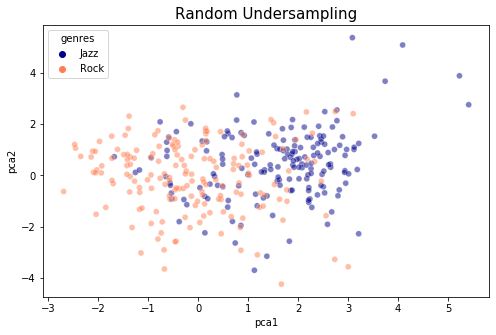

In [27]:
pca_2D(X_under,y_under,'Random Undersampling')

#### c.2) Condensed Nearest Neighbor (CNN)

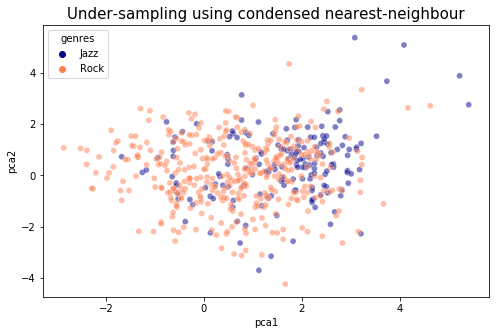

In [28]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour()
X_cnn, y_cnn = cnn.fit_resample(X, y)
#X_res_vis = pca.transform(X_resampled)
pca_2D(X_cnn,y_cnn,'Under-sampling using condensed nearest-neighbour')

#### c.3) Tomek's Link

In [29]:
#help(TomekLinks)

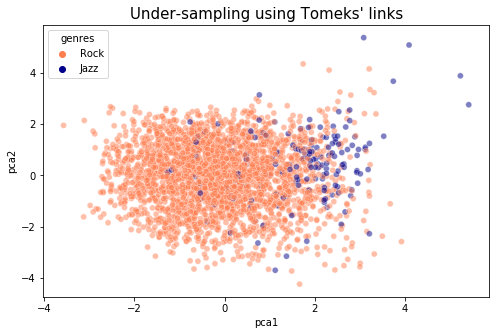

In [34]:
tomeks = TomekLinks(sampling_strategy='not minority')
X_tomek, y_tomek = tomeks.fit_resample(X, y)

pca_2D(X_tomek, y_tomek, 'Under-sampling using Tomeks\' links')

In [35]:
y_tomek.value_counts()

genre_top
1            2682
0             169
dtype: int64

#### c.4) Oversampling - Random

In [36]:
over_sample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = over_sample.fit_resample(X, y)

In [37]:
X_over.shape, y_over.shape

((5448, 8), (5448, 1))

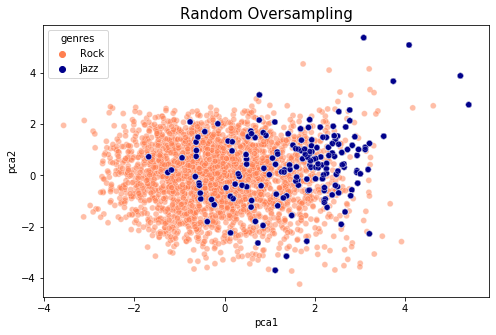

In [38]:
pca_2D(X_over, y_over, 'Random Oversampling')

#### c.5) SMOTE

In [39]:
smote_over = SMOTE()
X_smote, y_smote = smote_over.fit_resample(X, y)
X_smote.shape, y_smote.shape

((5448, 8), (5448, 1))

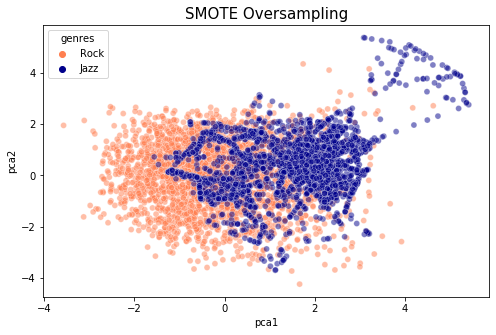

In [40]:
pca_2D(X_smote, y_smote, 'SMOTE Oversampling')

#### K-Means SMOTE

In [78]:
ksmote = KMeansSMOTE(random_state=42, sampling_strategy='not majority',kmeans_estimator=90, k_neighbors=5,cluster_balance_threshold=0.2)
X_ksmote, y_ksmote = ksmote.fit_resample(X, y)

In [79]:
y_ksmote.value_counts()

genre_top
0            2726
1            2724
dtype: int64

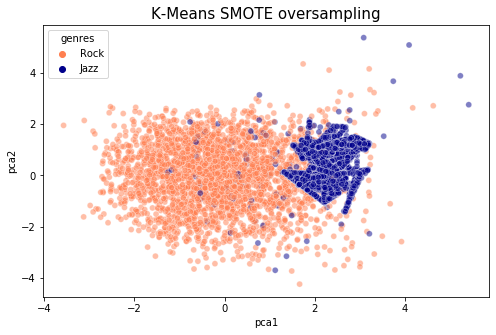

In [80]:
pca_2D(X_ksmote, y_ksmote, "K-Means SMOTE oversampling")

#### c.6) ADASYN

In [44]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

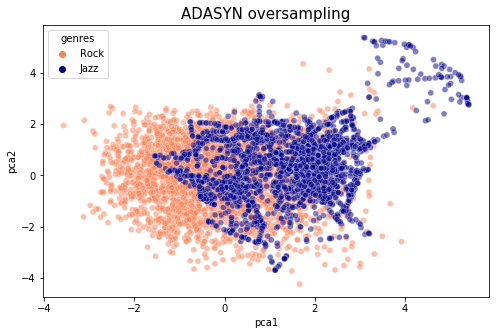

In [45]:
pca_2D(X_adasyn, y_adasyn, "ADASYN oversampling")

## d) Decision tree

### Random Search 

In [46]:
from sklearn.model_selection import RandomizedSearchCV

In [61]:
data =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]
params = {"criterion":["gini", "entropy"],
         "max_depth":[x for x in range(4,10)],
         "min_samples_split": [x for x in range(5,40)],
         "min_samples_leaf": [x for x in range(10,40)]}

for model, title in zip(data,titles):
    dt = DecisionTreeClassifier()
    clf = RandomizedSearchCV(estimator=dt, param_distributions=params, cv=5, n_iter=500, random_state=42,
                             verbose=True, return_train_score=True, scoring='f1_macro')
    search = clf.fit(model[0], model[1])
    print(f"*******{title}*******")
    print(search.best_params_)
    print(f"accuracy validation: {search.best_score_}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   43.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******unbalanced*******
{'min_samples_split': 6, 'min_samples_leaf': 11, 'max_depth': 7, 'criterion': 'entropy'}
accuracy validation: 0.6296100995231163
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******undersampling*******
{'min_samples_split': 12, 'min_samples_leaf': 38, 'max_depth': 6, 'criterion': 'entropy'}
accuracy validation: 0.7649988957445951
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   16.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******condensed NN*******
{'min_samples_split': 6, 'min_samples_leaf': 10, 'max_depth': 4, 'criterion': 'entropy'}
accuracy validation: 0.6260787284959727
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   43.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******Tomek links*******
{'min_samples_split': 14, 'min_samples_leaf': 10, 'max_depth': 8, 'criterion': 'entropy'}
accuracy validation: 0.6768190859981422
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   53.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******oversampling*******
{'min_samples_split': 16, 'min_samples_leaf': 10, 'max_depth': 9, 'criterion': 'gini'}
accuracy validation: 0.9178354184379097
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******SMOTE*******
{'min_samples_split': 7, 'min_samples_leaf': 12, 'max_depth': 9, 'criterion': 'gini'}
accuracy validation: 0.8727042151023717
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******K-means SMOTE*******
{'min_samples_split': 33, 'min_samples_leaf': 11, 'max_depth': 5, 'criterion': 'entropy'}
accuracy validation: 0.9613922435478053
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
*******ADASYN*******
{'min_samples_split': 14, 'min_samples_leaf': 24, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.7988737289702248


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  1.2min finished


### d.2) Retrain Models : Unbalanced vs Balanced

In [81]:
data_training =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

models ={
    
    'unbalanced':DecisionTreeClassifier(criterion= 'entropy',max_depth=7,
                                        min_samples_leaf= 11, min_samples_split=6),
   
    "undesampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=6,
                                        min_samples_leaf= 38, min_samples_split=12),
    
    "condensed NN":DecisionTreeClassifier(criterion= 'entropy',max_depth=4,
                                        min_samples_leaf= 10, min_samples_split=6),
    
    "Tomek links":DecisionTreeClassifier(criterion= 'entropy',max_depth=8,
                                        min_samples_leaf= 10, min_samples_split=14),
    
    "oversampling":DecisionTreeClassifier(criterion= 'gini',max_depth=9,
                                        min_samples_leaf= 10, min_samples_split=16),
    
    "SMOTE":DecisionTreeClassifier(criterion= 'gini',max_depth=9,
                                        min_samples_leaf= 12, min_samples_split=7),
    
    "k-means SMOTE":DecisionTreeClassifier(criterion= 'entropy',max_depth=5,
                                        min_samples_leaf= 11, min_samples_split=33),
    
    "ADASYN":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 24, min_samples_split=14)
}

roc_curves ={} #stores roc curves for each model
fpr_tpr = [] #stores false positive and true positive rates for each models
f1_scores_minc =[] # stores f1 score of minority class for each model
precision_minc=[]
recall_minc=[]

for model,data,title in zip(models, data_training, titles):
    dt = models[model]
    dt.fit(data[0],data[1])
    y_pred = dt.predict(X_test)

    # computes roc curve for each classifier
    y_score = dt.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    roc_curves[title] = roc_auc
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    fpr_tpr.append((fpr,tpr))
    
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])
    # save recall score of minority class
    recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
    # save precision score of minority class
    precision_minc.append(precision_score(y_test, y_pred, average=None)[0])
    
    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print('Recall %s' % recall_score(y_test, y_pred, average=None))
    print('Precision %s' % precision_score(y_test, y_pred,average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.9298387096774193
F1-score [0.20183486 0.96330662]

Recall [0.15277778 0.97773973]
Precision [0.2972973  0.94929343]
              precision    recall  f1-score   support

           0       0.30      0.15      0.20        72
           1       0.95      0.98      0.96      1168

    accuracy                           0.93      1240
   macro avg       0.62      0.57      0.58      1240
weighted avg       0.91      0.93      0.92      1240

*** undersampling classification ***
Accuracy 0.6782258064516129
F1-score [0.21301775 0.79776989]

Recall [0.75       0.67380137]
Precision [0.12413793 0.97763975]
              precision    recall  f1-score   support

           0       0.12      0.75      0.21        72
           1       0.98      0.67      0.80      1168

    accuracy                           0.68      1240
   macro avg       0.55      0.71      0.51      1240
weighted avg       0.93      0.68      0.76      1240

*** condensed NN clas

In [82]:
# classification with cost matrix
dt_w = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf= 20, min_samples_split=10, class_weight='balanced')
dt_w.fit(X, y)
y_pred_w = dt_w.predict(X_test)

# save f1, precision, recall scores of minority class
f1_scores_minc.append(f1_score(y_test, y_pred_w, average=None)[0])
recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
precision_minc.append(precision_score(y_test, y_pred, average=None)[0])

print(f"*** cost-matrix classification ***")
print('Accuracy %s' % accuracy_score(y_test, y_pred_w))
print('F1-score %s\n' % f1_score(y_test, y_pred_w, average=None))
print(classification_report(y_test, y_pred_w))


*** cost-matrix classification ***
Accuracy 0.7556451612903226
F1-score [0.2406015  0.85439692]

              precision    recall  f1-score   support

           0       0.15      0.67      0.24        72
           1       0.97      0.76      0.85      1168

    accuracy                           0.76      1240
   macro avg       0.56      0.71      0.55      1240
weighted avg       0.93      0.76      0.82      1240



Text(0.5, 0, '')

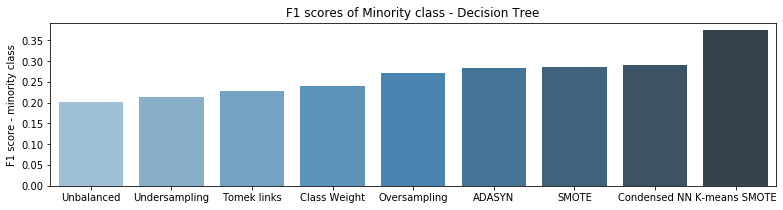

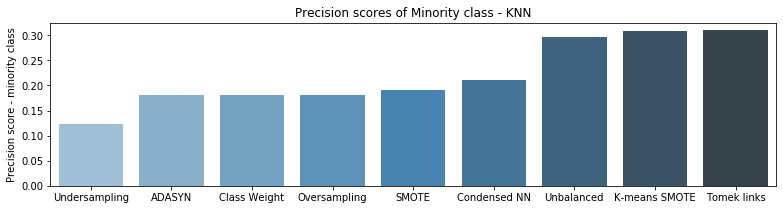

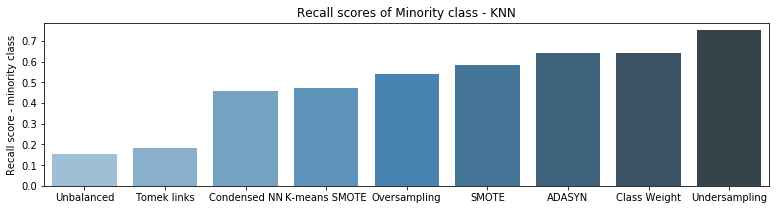

In [83]:
# plot F1 scores for minority class
df = pd.DataFrame()
df['f1'] = f1_scores_minc
df['precision'] = precision_minc
df['recall'] = recall_minc
df['models'] = ['Unbalanced','Undersampling','Condensed NN','Tomek links','Oversampling','SMOTE','K-means SMOTE',
                'ADASYN', 'Class Weight']


plt.figure(figsize=(13,3))
sns.barplot(x="models", y="f1", data=df.sort_values(by='f1'), palette="Blues_d")
plt.ylabel('F1 score - minority class')
plt.title('F1 scores of Minority class - Decision Tree')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="precision", data=df.sort_values(by='precision'), palette="Blues_d")
plt.ylabel('Precision score - minority class')
plt.title('Precision scores of Minority class - Decision Tree')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="recall", data=df.sort_values(by='recall'), palette="Blues_d")
plt.ylabel('Recall score - minority class')
plt.title('Recall scores of Minority class - Decision Tree')
plt.xlabel(None)

### d.3) Compare results

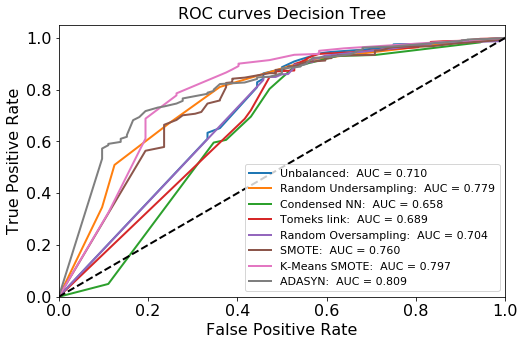

In [86]:
# plot roc curves
plt.figure(figsize=(8,5))

plt.plot(fpr_tpr[0][0], fpr_tpr[0][1], lw=2, label='Unbalanced:  AUC = %.3f' % roc_curves['unbalanced'])
plt.plot(fpr_tpr[1][0], fpr_tpr[1][1], lw=2, label='Random Undersampling:  AUC = %.3f' % roc_curves['undersampling'])
plt.plot(fpr_tpr[2][0], fpr_tpr[2][1], lw=2, label='Condensed NN:  AUC = %.3f' % roc_curves['condensed NN'])
plt.plot(fpr_tpr[3][0], fpr_tpr[3][1], lw=2, label='Tomeks link:  AUC = %.3f' % roc_curves['Tomek links'])
plt.plot(fpr_tpr[4][0], fpr_tpr[4][1], lw=2, label='Random Oversampling:  AUC = %.3f' % roc_curves['oversampling'])
plt.plot(fpr_tpr[5][0], fpr_tpr[5][1], lw=2, label='SMOTE:  AUC = %.3f' % roc_curves['SMOTE'])
plt.plot(fpr_tpr[6][0], fpr_tpr[6][1], lw=2, label='K-Means SMOTE:  AUC = %.3f' % roc_curves['K-means SMOTE'])
plt.plot(fpr_tpr[7][0], fpr_tpr[7][1], lw=2, label='ADASYN:  AUC = %.3f' % roc_curves['ADASYN'])


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves Decision Tree', fontsize=16)
plt.legend(loc="lower right", fontsize=11, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## d) KNN

### Random Search 

In [87]:
data =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

params = {"weights":["distance", "uniform"],
         "n_neighbors":[x for x in range(3,25)],
         "metric": ["euclidean", "manhattan", "minkowski", "chebyshev"],
         }

for model, title in zip(data,titles):
    knn = KNeighborsClassifier()
    clf = RandomizedSearchCV(estimator=knn, param_distributions=params, cv=5, n_iter=200, random_state=42,
                             verbose=True, return_train_score=True, )
    search = clf.fit(model[0], model[1])
    print(f"*******{title}*******")
    print(search.best_params_)
    print(f"accuracy validation: {search.best_score_}")

Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******unbalanced*******
{'weights': 'uniform', 'n_neighbors': 12, 'metric': 'euclidean'}
accuracy validation: 0.9474580322833187
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******undersampling*******
{'weights': 'distance', 'n_neighbors': 9, 'metric': 'chebyshev'}
accuracy validation: 0.8046532045654082
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:   17.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******condensed NN*******
{'weights': 'distance', 'n_neighbors': 24, 'metric': 'euclidean'}
accuracy validation: 0.7262899262899263
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******Tomek links*******
{'weights': 'distance', 'n_neighbors': 11, 'metric': 'euclidean'}
accuracy validation: 0.9498429962822994
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******oversampling*******
{'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'}
accuracy validation: 0.9669588293274698
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******SMOTE*******
{'weights': 'distance', 'n_neighbors': 4, 'metric': 'euclidean'}
accuracy validation: 0.9445644097353856
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******K-means SMOTE*******
{'weights': 'distance', 'n_neighbors': 6, 'metric': 'euclidean'}
accuracy validation: 0.9554128440366974
Fitting 5 folds for each of 176 candidates, totalling 880 fits
*******ADASYN*******
{'weights': 'distance', 'n_neighbors': 4, 'metric': 'euclidean'}
accuracy validation: 0.9289204379488523


[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:  4.0min finished


### Retrain Models: Unbalanced vs Balanced

In [88]:

models ={
    
    'unbalanced':KNeighborsClassifier(n_neighbors = 12, weights='uniform', metric='euclidean'),
   
    "undesampling":KNeighborsClassifier(n_neighbors = 9, weights='distance', metric='chebyshev'),
    
    "condensed NN":KNeighborsClassifier(n_neighbors = 24, weights='distance', metric='euclidean'),
    
    "Tomek links":KNeighborsClassifier(n_neighbors = 11, weights='distance', metric='euclidean'),
    
    "oversampling":KNeighborsClassifier(n_neighbors = 3, weights='distance', metric='euclidean'),
    
    "SMOTE":KNeighborsClassifier(n_neighbors = 4, weights='distance', metric='euclidean'),
    
    "k-means SMOTE":KNeighborsClassifier(n_neighbors = 6, weights='distance', metric='euclidean'),
    
    "ADASYN":KNeighborsClassifier(n_neighbors = 4, weights='distance', metric='euclidean')
    
}

roc_curves_knn ={}
fpr_tpr_knn = []
f1_scores_minc = []
recall_minc = []
precision_minc =[]

for model, data, title in zip(models, data_training, titles):
    knn = models[model]
    knn.fit(data[0],data[1])
    y_pred = knn.predict(X_test)

    # computes roc curve for each classifier
    y_score = knn.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc_knn = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    roc_curves_knn[title] = roc_auc_knn
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    fpr_tpr_knn.append((fpr,tpr))
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])   
    # save recall score of minority class
    recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
    # save precision score of minority class
    precision_minc.append(precision_score(y_test, y_pred, average=None)[0])
    
    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.9403225806451613
F1-score [0.26       0.96890756]

              precision    recall  f1-score   support

           0       0.46      0.18      0.26        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.71      0.58      0.61      1240
weighted avg       0.92      0.94      0.93      1240

*** undersampling classification ***
Accuracy 0.7943548387096774
F1-score [0.28571429 0.87988695]

              precision    recall  f1-score   support

           0       0.18      0.71      0.29        72
           1       0.98      0.80      0.88      1168

    accuracy                           0.79      1240
   macro avg       0.58      0.75      0.58      1240
weighted avg       0.93      0.79      0.85      1240

*** condensed NN classification ***
Accuracy 0.932258064516129
F1-score [0.35384615 0.96425532]

              precision    recall  f1-score   support


The condensed NearestNeighbor is the balancing technique yeilding the best results.<br>
The f1 score for class 0 goes from 0.24 to 0.38. This is due to the fact that **recall** improved as well, going from
0.15 in the unbalanced case (the classifier was not able to detect class 0) to 0.32 with the CNN. <br>
The precision decreses of few percent points (from 0.58 to 0.46) which is still acceptable considering the high recall.<br>
In terms of **recall**, **ADASYN** and **Random Undersampling** yeilded the highest recall (0.71 and 0.72 respectively). However after this rebalancing, although the f1 score increased to approximately 0.30, the precision of the model for that class resulted to be very low (0.19 for both). This means that in order to predict class 0 the classifier started to assign label 0 to more samples including those for which the real target was class 1.

Text(0.5, 0, '')

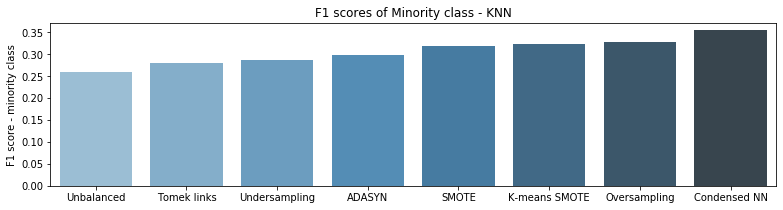

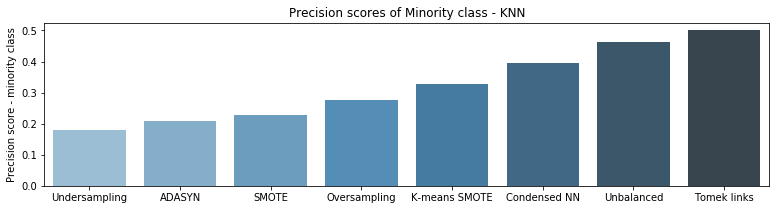

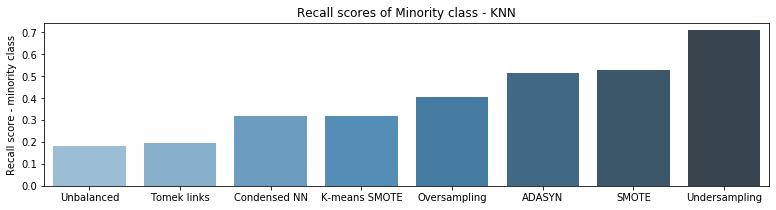

In [89]:
# plot F1 scores for minority class
df = pd.DataFrame()
df['f1'] = f1_scores_minc
df['precision'] = precision_minc
df['recall'] = recall_minc
df['models'] = ['Unbalanced','Undersampling','Condensed NN','Tomek links','Oversampling','SMOTE','K-means SMOTE',
                'ADASYN']


plt.figure(figsize=(13,3))
sns.barplot(x="models", y="f1", data=df.sort_values(by='f1'), palette="Blues_d")
plt.ylabel('F1 score - minority class')
plt.title('F1 scores of Minority class - KNN')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="precision", data=df.sort_values(by='precision'), palette="Blues_d")
plt.ylabel('Precision score - minority class')
plt.title('Precision scores of Minority class - KNN')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="recall", data=df.sort_values(by='recall'), palette="Blues_d")
plt.ylabel('Recall score - minority class')
plt.title('Recall scores of Minority class - KNN')
plt.xlabel(None)

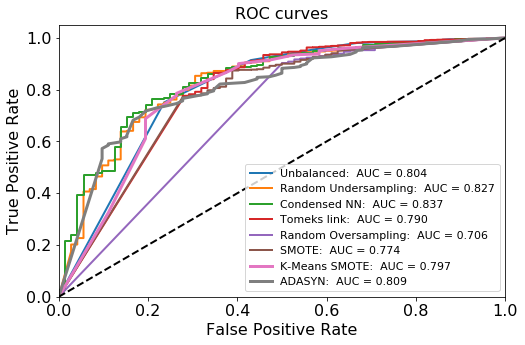

In [90]:
# plot roc curves
plt.figure(figsize=(8,5))

plt.plot(fpr_tpr_knn[0][0], fpr_tpr_knn[0][1], lw=2, label='Unbalanced:  AUC = %.3f' % roc_curves_knn['unbalanced'])
plt.plot(fpr_tpr_knn[1][0], fpr_tpr_knn[1][1], lw=2, label='Random Undersampling:  AUC = %.3f' % roc_curves_knn['undersampling'])
plt.plot(fpr_tpr_knn[2][0], fpr_tpr_knn[2][1], lw=2, label='Condensed NN:  AUC = %.3f' % roc_curves_knn['condensed NN'])
plt.plot(fpr_tpr_knn[3][0], fpr_tpr_knn[3][1], lw=2, label='Tomeks link:  AUC = %.3f' % roc_curves_knn['Tomek links'])
plt.plot(fpr_tpr_knn[4][0], fpr_tpr_knn[4][1], lw=2, label='Random Oversampling:  AUC = %.3f' % roc_curves_knn['oversampling'])
plt.plot(fpr_tpr_knn[5][0], fpr_tpr_knn[5][1], lw=2, label='SMOTE:  AUC = %.3f' % roc_curves_knn['SMOTE'])
plt.plot(fpr_tpr[6][0], fpr_tpr[6][1], lw=3, label='K-Means SMOTE:  AUC = %.3f' % roc_curves['K-means SMOTE'])
plt.plot(fpr_tpr[7][0], fpr_tpr[7][1], lw=3, label='ADASYN:  AUC = %.3f' % roc_curves['ADASYN'])



plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=11, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()